# Exploring Key Factors Influencing GitHub Repository Popularity

**Questions of Interest** What factors significantly influence the popularity of a repository (i.e., the number of Stars)? Can we predict the number of Stars a repository receives using these factors?

In [48]:
# Load library
suppressPackageStartupMessages({
    library(readr)
    library(rsample)
    library(broom)
    library(latex2exp)
    library(tidymodels)
    library(repr)
    library(gridExtra)
    library(faraway)
    library(mltools)
    library(leaps)
    library(glmnet)
    library(cowplot)
    library(tidyverse)
    library(modelr)
    library(car)
})

## Introduction

## Methods and Results

- data description + EDA   **I listed all our variables and their description in my previous assignment, should we also do that here??**
- Clean the dataset
- (prediction)split training&test **done**
- baseline model  **done**
- forward selection  **done**
- fit the model  **done**
- assumptions??  
- interpret their coefficients
- (prediction) maybe cross-valiation on the training set
- (prediction) test the model on the test set

FEEL FREE TO EDIT!!

### a) Exploratory Data Analysis (EDA)

This dataset contains information on over 215k top repositories (projects) on Github by star with over 167 stars. The data is collected using github search api, which can be used to get only the first thousand for a query, so the author looped through the low/high (stars) pairs that return less than a thousand repositories when query=stars:{low}..{high}. The data is from the Github website. Finally, 215,029 observations are collected along with 24 variables.

- Demonstrate that the dataset can be read into R.
- Clean and wrangle your data into a tidy format.
- Plot the relevant raw data, tailoring your plot to address your question.
- Make sure to explore the association of the explanatory variables with the response.
- Any summary tables that are relevant to your analysis.
- Be sure not to print output that takes up a lot of screen space.
- Your EDA must be comprehensive with high quality plots.

In [49]:
# read the dataset
repositories <- read.csv("repositories.csv")

head(repositories, n=3)

Name                  
1 freeCodeCamp          
2 free-programming-books
3 awesome               
  Description                                                                    
1 freeCodeCamp.org's open-source codebase and curriculum. Learn to code for free.
2 :books: Freely available programming books                                     
3 😎 Awesome lists about all kinds of interesting topics                         
  URL                                                      
1 https://github.com/freeCodeCamp/freeCodeCamp             
2 https://github.com/EbookFoundation/free-programming-books
3 https://github.com/sindresorhus/awesome                  
  Created.At           Updated.At          
1 2014-12-24T17:49:19Z 2023-09-21T11:32:33Z
2 2013-10-11T06:50:37Z 2023-09-21T11:09:25Z
3 2014-07-11T13:42:37Z 2023-09-21T11:18:22Z
  Homepage                                                  Size   Stars  Forks
1 http://contribute.freecodecamp.org/                       387451 374074 33599
2 https://ebookfoundation.github.io/free-programming-books/  17087 298393 57194
3                                                             1441 269997 26485
  Issues ⋯ Has.Issues Has.Projects Has.Downloads Has.Wiki Has.Pages
1 248    ⋯ True       True         True          False    True     
2  46    ⋯ True       False        True          False    True     
3  61    ⋯ True       False        True          False    True     
  Has.Discussions Is.Fork Is.Archived Is.Template Default.Branch
1 False           False   False       False       main          
2 False           False   False       False       main          
3 False           False   False       False       main

In [50]:
# Remove rows with missing values
repo_tidy <- repositories %>%
    drop_na()

#Filter relevant columns and convert boolean columns to binary(1/0)
data_repo_clean <- repo_tidy %>% 
select(Size, Stars, Forks, Issues, Has.Issues, Has.Projects, Has.Downloads, Has.Wiki, Has.Pages, Has.Discussions, Is.Archived, Is.Template) %>%
mutate(across(c(Has.Issues, Has.Projects, Has.Downloads, Has.Wiki, Has.Pages, Has.Discussions, Is.Archived, Is.Template),
                ~ as.numeric(. == "True")))

head(data_repo_clean,n=3)

Size   Stars  Forks Issues Has.Issues Has.Projects Has.Downloads Has.Wiki
1 387451 374074 33599 248    1          1            1             0       
2  17087 298393 57194  46    1          0            1             0       
3   1441 269997 26485  61    1          0            1             0       
  Has.Pages Has.Discussions Is.Archived Is.Template
1 1         0               0           0          
2 1         0               0           0          
3 1         0               0           0

### b) Methods

Methods: Plan”

Describe in written English the methods you used to perform your analysis from beginning to end, and narrate the code that does the analysis.
If included, describe the “Feature Selection” process and how and why you choose the covariates of your final model.
Make sure to interpret/explain the results you obtain. It’s not enough to just say, “I fitted a linear model with these covariates, and my R-square is 0.87”.
If inference is the aim of your project, a detailed interpretation of your fitted model is required, as well as a discussion of relevant quantities (e.g., are the coefficients significant? How does the model fit the data)?
A careful model assessment must be conducted.
If prediction is the project's aim, describe the test data used or how it was created.
Ensure your tables and/or figures are labelled with a figure/table number.

#### data split

In [51]:
# Split the dataset in 0.6
set.seed(123)

repo_split <- 
    data_repo_clean %>%
    initial_split(prop = 0.6, strata = Stars)

training_repo <- training(repo_split)
testing_repo <- testing(repo_split)

#### baseline model

In [52]:
# fit the full model

repo_full_OLS <- lm(Stars ~ ., data = training_repo)
repo_full_OLS_results <- tidy(repo_full_OLS)

repo_full_OLS_results

# predit on the testing dataset
testing_repo <- testing_repo |>
    add_predictions(repo_full_OLS, var="pred_full_OLS")

term            estimate      std.error    statistic   p.value      
1  (Intercept)      1.113818e+03 1.039536e+02  10.7145697  8.924855e-27
2  Size             3.378433e-06 1.254491e-05   0.2693071  7.876938e-01
3  Forks            1.656748e+00 7.217402e-03 229.5490060  0.000000e+00
4  Issues           2.756035e+00 4.558267e-02  60.4623581  0.000000e+00
5  Has.Issues       2.399161e+01 5.301769e+01   0.4525209  6.508945e-01
6  Has.Projects    -2.563964e+02 3.292043e+01  -7.7883674  6.838210e-15
7  Has.Downloads   -2.464407e+02 9.448540e+01  -2.6082410  9.101935e-03
8  Has.Wiki        -2.201769e+02 2.810511e+01  -7.8340519  4.759655e-15
9  Has.Pages        2.217952e+02 2.367166e+01   9.3696515  7.389200e-21
10 Has.Discussions  7.682286e+02 2.773443e+01  27.6994580 2.214656e-168
11 Is.Archived     -1.402855e+02 3.674903e+01  -3.8173918  1.349329e-04
12 Is.Template     -4.092400e+02 1.140407e+02  -3.5885422  3.326552e-04

In [53]:
# RMSE of the full model
rmse_full <- 
    testing_repo %>% 
    mutate(pred_error = Stars - pred_full_OLS) %>%
    summarise(RMSE = sqrt(mean(pred_error ^ 2))) %>%
    pull()


repo_RMSE_models <- tibble(
  Model = "OLS Full Regression",
  RMSE = rmse_full)

repo_RMSE_models

Model               RMSE    
1 OLS Full Regression 3146.908

#### forward selection

In [54]:
# current number of columns in the wrangled dataset
length(colnames(data_repo_clean))

[1] 12

In [55]:
head(training_repo, n=3)

Size   Stars Forks Issues Has.Issues Has.Projects Has.Downloads Has.Wiki
1   2411 237    32   36     1          1            1             0       
2 169493 237   125   62     1          1            1             1       
3    685 237    28    9     1          1            1             1       
  Has.Pages Has.Discussions Is.Archived Is.Template
1 0         0               0           0          
2 0         1               0           0          
3 0         1               0           0

In [56]:
# forward selection
repo_forward_sel <- regsubsets(x = Stars ~ ., nvmax = 12-1,
                                  data = training_repo,
                                  method = "forward")
repo_forward_summary <- summary(repo_forward_sel)
repo_forward_summary

Subset selection object
Call: regsubsets.formula(x = Stars ~ ., nvmax = 12 - 1, data = training_repo, 
    method = "forward")
11 Variables  (and intercept)
                Forced in Forced out
Size                FALSE      FALSE
Forks               FALSE      FALSE
Issues              FALSE      FALSE
Has.Issues          FALSE      FALSE
Has.Projects        FALSE      FALSE
Has.Downloads       FALSE      FALSE
Has.Wiki            FALSE      FALSE
Has.Pages           FALSE      FALSE
Has.Discussions     FALSE      FALSE
Is.Archived         FALSE      FALSE
Is.Template         FALSE      FALSE
1 subsets of each size up to 11
Selection Algorithm: forward
          Size Forks Issues Has.Issues Has.Projects Has.Downloads Has.Wiki
1  ( 1 )  " "  "*"   " "    " "        " "          " "           " "     
2  ( 1 )  " "  "*"   "*"    " "        " "          " "           " "     
3  ( 1 )  " "  "*"   "*"    " "        " "          " "           " "     
4  ( 1 )  " "  "*"   "*"    " "       

In [59]:
repo_forward_summary_df <- tibble(
    n_input_variables = 1:11,
    RSQ = repo_forward_summary$rsq,
    RSS = repo_forward_summary$rss,
    ADJ_R2 = repo_forward_summary$adjr2,
    Cp = repo_forward_summary$cp,
    BIC = repo_forward_summary$bic,
)
repo_forward_summary_df

n_input_variables RSQ       RSS          ADJ_R2    Cp          BIC      
1   1                0.3333308 1.395552e+12 0.3333257 5468.749781 -52287.46
2   2                0.3534470 1.353442e+12 0.3534370 1412.898041 -56228.60
3   3                0.3583562 1.343166e+12 0.3583413  424.619700 -57200.16
4   4                0.3595923 1.340578e+12 0.3595724  177.279653 -57437.17
5   5                0.3600232 1.339676e+12 0.3599984   92.360638 -57512.24
6   6                0.3603109 1.339074e+12 0.3602812   36.316745 -57558.49
7   7                0.3603823 1.338925e+12 0.3603476   23.922696 -57561.12
8   8                0.3604465 1.338790e+12 0.3604069   12.958281 -57562.31
9   9                0.3604797 1.338721e+12 0.3604351    8.271656 -57557.23
10 10                0.3604807 1.338719e+12 0.3604311   10.072526 -57545.66
11 11                0.3604810 1.338718e+12 0.3604265   12.000000 -57533.97

**The forward algorithm would select a generative model with 9 variables using the adjusted $R^2$**.

**The forward algorithm would select a predictive model with 8 variables using BIC**.

**The forward algorithm would select a predictive model with 9 variables using Cp**.

In [68]:
# I use min cp value here to select variables for no reasons (we used in worksheet)... please change to other metrics if more reasonable!!!
cp_min = which.min(repo_forward_summary$cp) 

selected_var <- names(coef(repo_forward_sel, cp_min))[-1]
selected_var

[1] "Forks"           "Issues"          "Has.Projects"    "Has.Downloads"  
[5] "Has.Wiki"        "Has.Pages"       "Has.Discussions" "Is.Archived"    
[9] "Is.Template"

In [69]:
# subset only the predictors selected from the full dataset
training_subset <- 
    training_repo %>% 
    select(all_of(selected_var), Stars)

testing_subset <- 
    testing_repo %>% 
    select(all_of(selected_var), Stars)

head(training_subset, n=3)

Forks Issues Has.Projects Has.Downloads Has.Wiki Has.Pages Has.Discussions
1  32   36     1            1             0        0         0              
2 125   62     1            1             1        0         1              
3  28    9     1            1             1        0         1              
  Is.Archived Is.Template Stars
1 0           0           237  
2 0           0           237  
3 0           0           237

#### fit the model

In [70]:
# Fitting the model using the selected predictors

model = lm(Stars ~ ., data = training_subset)
summary(model)


Call:
lm(formula = Stars ~ ., data = training_subset)

Residuals:
    Min      1Q  Median      3Q     Max 
-399632    -509    -278     -59  316872 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.132e+03  9.574e+01  11.828  < 2e-16 ***
Forks            1.657e+00  7.213e-03 229.672  < 2e-16 ***
Issues           2.757e+00  4.555e-02  60.529  < 2e-16 ***
Has.Projects    -2.553e+02  3.283e+01  -7.777 7.47e-15 ***
Has.Downloads   -2.439e+02  9.431e+01  -2.586 0.009714 ** 
Has.Wiki        -2.185e+02  2.786e+01  -7.843 4.44e-15 ***
Has.Pages        2.222e+02  2.366e+01   9.389  < 2e-16 ***
Has.Discussions  7.691e+02  2.768e+01  27.791  < 2e-16 ***
Is.Archived     -1.418e+02  3.659e+01  -3.877 0.000106 ***
Is.Template     -4.095e+02  1.140e+02  -3.591 0.000330 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3221 on 129006 degrees of freedom
Multiple R-squared:  0.3605,	Adjusted R-squared:  0.3604 
F-

#### Interpretation of the predictors
From the forward selection LR model:

**Significant Positive Predictors**:

Forks: The number of forks is the strongest predictor, indicating repositories that are frequently forked tend to be more popular. </br>
Issues: A higher number of issues correlates with more Stars, possibly reflecting an active and engaged user base. </br>
Has.Pages and Has.Discussions: Repositories with GitHub Pages and Discussions enabled tend to have more Stars.

**Significant Negative Predictors**:

Has.Projects, Has.Downloads, and Has.Wiki: These features negatively influence the number of Stars, suggesting they might not be relevant to popularity or could be associated with less prominent projects. </br>
Is.Archived and Is.Template: Archived repositories and templates are less likely to receive Stars, likely because they are not actively maintained.

In [71]:
#As we can see every p value is lower than the significant value, so all the predictors here has significantly impact on our response
#now check the interaction term
#model_interactive = lm(Stars ~ Forks * Issues * Has.Projects * Has.Downloads * Has.Wiki * Has.Pages * Has.Discussions * Is.Archived * Is.Template, data = training_subset)
#summary(model_interactive)
#this won't work, so we might ignore the inte

#### Compare RMSE of the full model to the reduced model

In [72]:
# reduced model
rmse_red <- 
    testing_subset %>%
    add_predictions(model, var = 'pred_reduced_reg') %>%
    mutate(pred_red_error = Stars - pred_reduced_reg) %>%
    summarize(RMSE = sqrt(mean(pred_red_error^2))) %>%
    pull()      

repo_RMSE_models_expanded <- 
    bind_rows(
        repo_RMSE_models,
        tibble(Model = "OLS Reduced Regression",
               RMSE = rmse_red)
    )

repo_RMSE_models_expanded

Model                  RMSE    
1 OLS Full Regression    3146.908
2 OLS Reduced Regression 3146.949

In [73]:
# a little higher rmse for our reduced model..

#### Check Check Linearity, Homoscedasticity and Normality of residuals

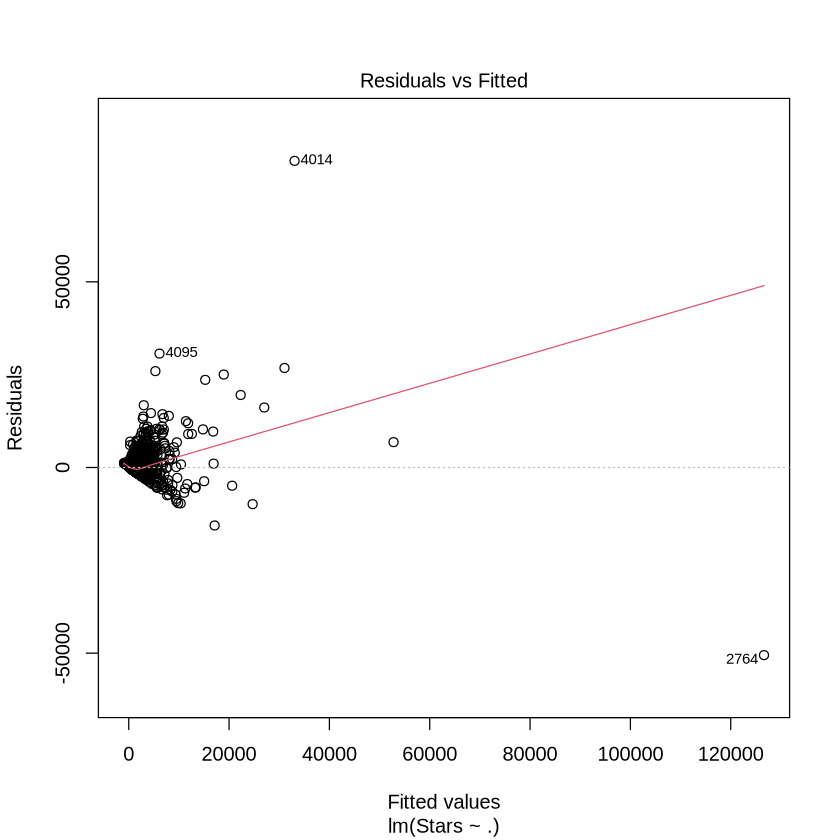

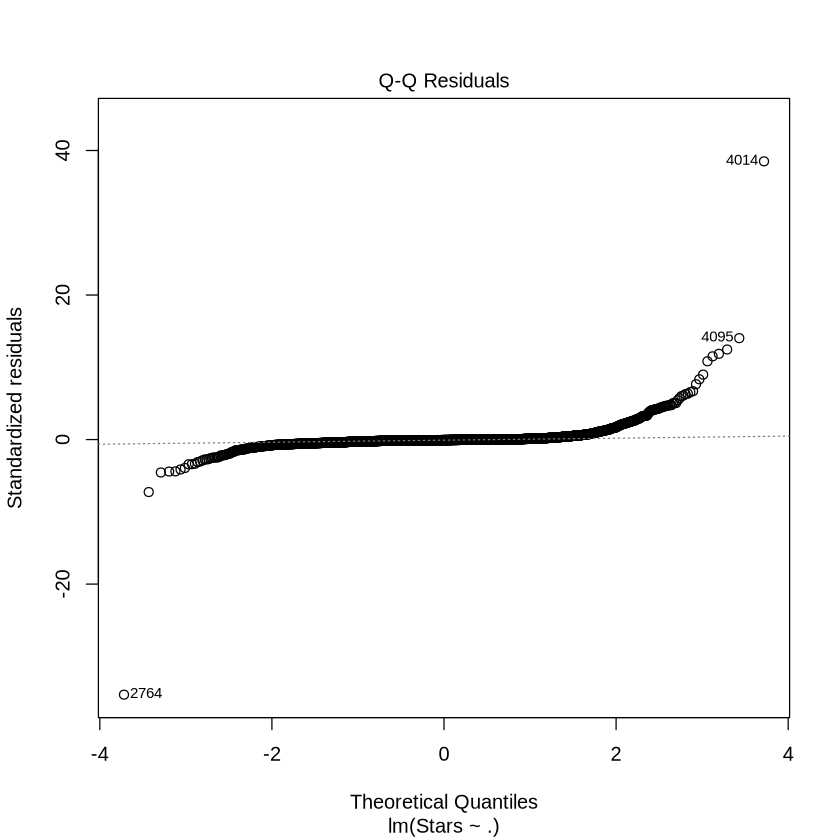

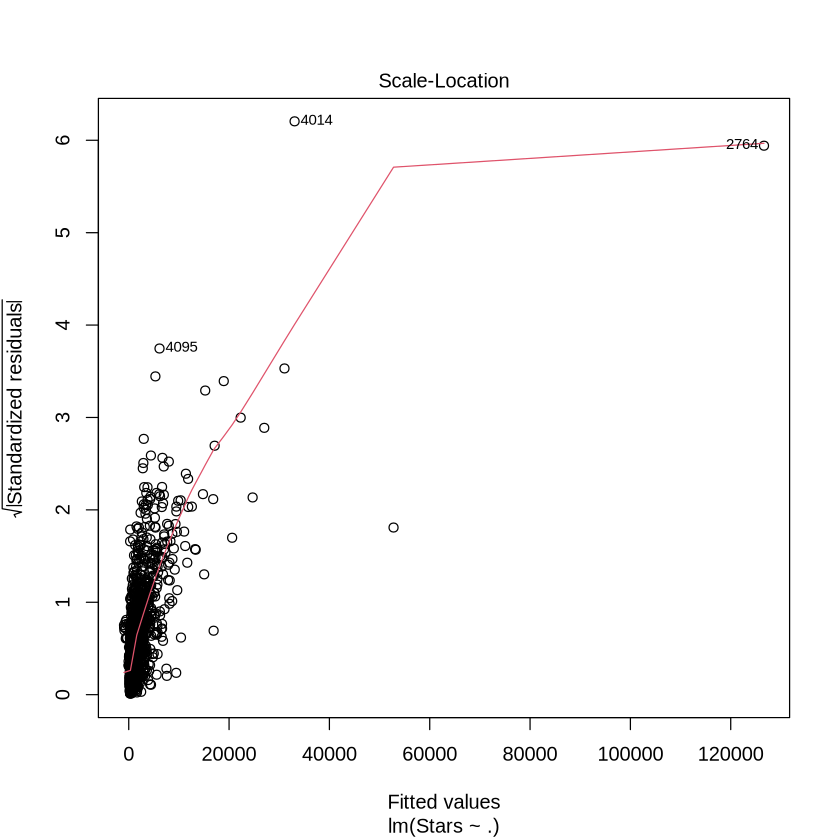

In [75]:
# the plots don't show good outcomes...should we just skip the assumptions??

set.seed(123)
training_sample  <- rep_sample_n(training_subset, size = 5000, replace = FALSE)

model_sample <- lm(Stars ~ ., data = training_sample)

plot(model_sample, which = 1)  # Residuals vs Fitted
plot(model_sample, which = 2)  # Q-Q plot
plot(model_sample, which = 3) # Scale-Location Plot

#### Check multicollinearity

In [76]:
# Calculate VIF for each predictor
vif_values <- vif(model)

print(vif_values)

          Forks          Issues    Has.Projects   Has.Downloads        Has.Wiki 
       1.088197        1.095439        1.549572        1.018146        1.578287 
      Has.Pages Has.Discussions     Is.Archived     Is.Template 
       1.011969        1.039269        1.012324        1.001308 


The VIF values for all predictors are below 2, indicating no significant multicollinearity in our model.

## Discussion

Assumptions of Linearity, Homoscedasticity and Normality of residuals not met because...

- Non-linear model?
- Too many variables causing overfitting?

## References